# TP SVG

### Data Structures

- List of tupples for (shape, color, coordinates)?


### Functions to implement:
- computing an SVG from a genotype;
- computing a PNG from a phenotype;
- computing a phenotype from a genotype;
- computing a fitness value from a phenotype;
- mutating a genotype;
- performing a crossover between two genotypes.

## Code a skeleton application
First, focus on the overall code structure and solution representation. 
Write a first version of your main script that loads the target image, create a “blank” approximation and compute its fitness without implementing any improvement algorithm yet. 
Test your solution representation by generating a random solution with one simple geometric shape (e.g., one square aligned with the pixel grid) to ensure the code structure works as expected

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from genotype import SVGShape, Circle, Ellipse, Rect

def load_img(image_path: str):
    img = Image.open(image_path)
    # Creates an array: [height, width, channels]
    grid = np.array(img)
    w = img.width
    h = img.height
    return (grid, w, h)




def generate_phenotype(width, height, genotype):
    # Create a blank image (canvas) to draw on. 
    img = Image.new("RGB", (width, height), "black") 
    draw = ImageDraw.Draw(img)

    for shape in genotype:
        # We render each shape 
        
        if isinstance(shape, Rect):
            # From (x, y, w, h) to (x0, y0, x1, y1)
            x1 = shape.x + shape.w
            y1 = shape.y + shape.h
            draw.rectangle([shape.x, shape.y, x1, y1], fill=shape.fill)
            
        elif isinstance(shape, Circle):
            # (cx-r, cy-r, cx+r, cy+r)
            x0 = shape.cx - shape.r
            y0 = shape.cy - shape.r
            x1 = shape.cx + shape.r
            y1 = shape.cy + shape.r
            draw.ellipse([x0, y0, x1, y1], fill=shape.fill)

        elif isinstance(shape, Ellipse):
            # (cx-rx, cy-ry, cx+rx, cy+ry)
            x0 = shape.cx - shape.rx
            y0 = shape.cy - shape.ry
            x1 = shape.cx + shape.rx
            y1 = shape.cy + shape.ry
            draw.ellipse([x0, y0, x1, y1], fill=shape.fill)

    # Convert back to a nparray for fitness calc
    return np.array(img)


# Calculate distance between phenotype and original image
# TODO: Check if other fitness calc are worth it
def compute_fitness(target, candidate):
    """
    Computes the Sum of Squared Differences between two img and phenotype.
    """
    # Cast to int64 because of squares
    diff = target.astype(np.int64) - candidate.astype(np.int64)
    
    # Square the differences and sum them up (L2 Norm penalizes large diff)
    return np.sum(diff ** 2)






## 1st Test

Very simple test, checking if starting logic works - i.e fitness looks logical and drawing shapes seems to work.

Base Fitness (Empty): 311127167257
Genotype size: 1 shape(s)
Fitness Score: 311180064712
Improvement: -52897455


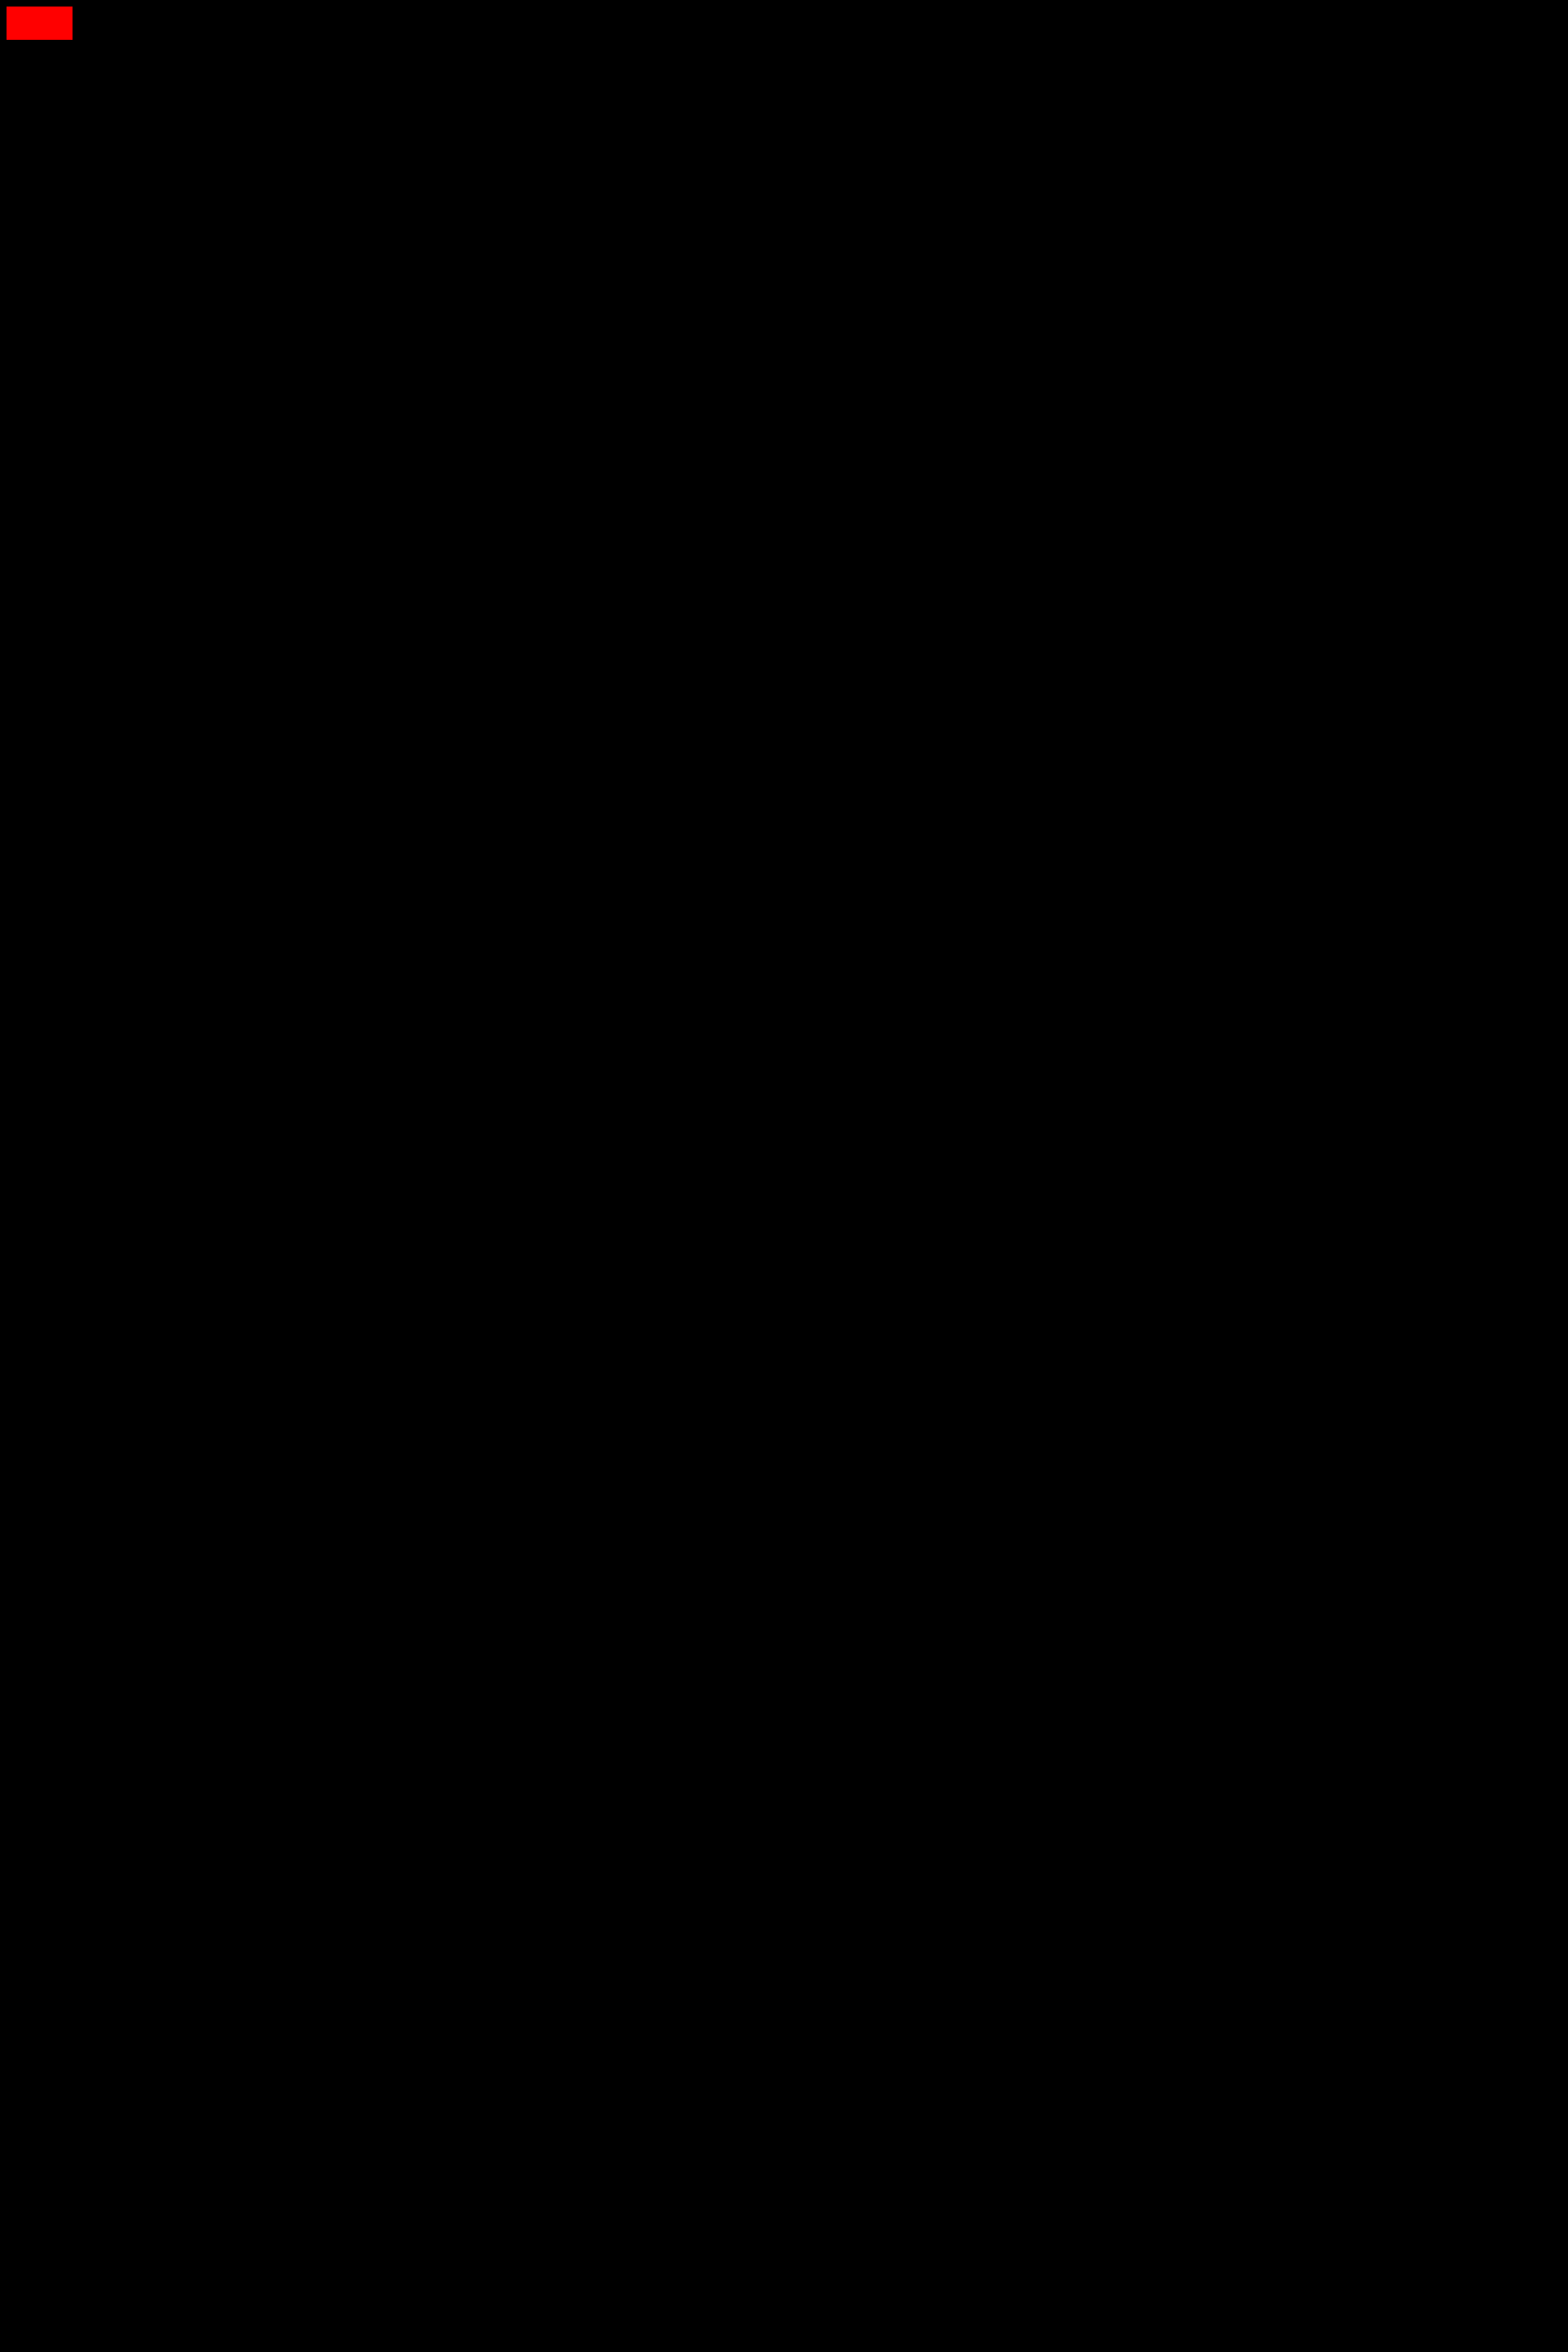

In [2]:
original_img, w, h = load_img("./test.png")

# Create blank canvas (All Black)
canvas = np.zeros(original_img.shape, dtype=np.uint8)
shapes = ["Rect", "Circle", "Ellipse"]

# TEST: Check fitness of empty canvas (Canvas vs Original)
# This gives you the "worst case" score to beat
base_fitness = compute_fitness(original_img, canvas)
print(f"Base Fitness (Empty): {base_fitness}")

# Create data structure -> list of tuples (genotype)
gen: list[SVGShape] = []

# Add 1 random (shape, color, coordinates)
new_rect = Rect(x=10, y=10, w=100, h=50, fill=(255, 0, 0))
gen.append(new_rect)

# Create corresponding pixel grid (phenotype)
phenotype = generate_phenotype(w, h, gen)

# Calculate distance between phenotype and original image (fitness)
fitness_score = compute_fitness(original_img, phenotype)

# Results
print(f"Genotype size: {len(gen)} shape(s)")
print(f"Fitness Score: {fitness_score}")
print(f"Improvement: {base_fitness - fitness_score}")

# Show generated img
gen_img = Image.fromarray(phenotype)
display(gen_img)

## Heuristics and Metaheuristics

### How to start well?
- Get the base colors of the image:
    - for example, make a grid of the image and take the average color of these rectangles?
    - Take the top 5-10 hues and start with a shape of each?

- Change the image size so there are fewer pixels and therefore a simpler problem

We'll start with the resize (because that will simplify visualization too) and we'll also define random sizes and colors.

In [3]:
import random

def load_img(image_path: str, max_size=512):
    img = Image.open(image_path)
    
    # Resize while maintaining aspect ratio
    img.thumbnail((max_size, max_size))
    
    # Ensure we are in RGB mode (removes Alpha channel if present, which simplifies math)
    img = img.convert("RGB")
    
    # Creates an array: [height, width, channels]
    grid = np.array(img)
    w = img.width
    h = img.height
    
    print(f"Image loaded and resized to: {w}x{h}")
    return (grid, w, h)


# Generates a random shape (Rect, Circle, Ellipse) with randomized size and position.
def get_random_shape(shape: type[SVGShape], w_img: int, h_img: int, min_size: int = 25): # TODO: check if 25 is not to big 

    # Random color (R, G, B)
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    if shape == Rect:
        # Width/Height: Random between min_size and full image size
        w = random.randint(min_size, w_img)
        h = random.randint(min_size, h_img)
        
        # X/Y: Position can be anywhere inside
        x = random.randint(0, w_img - w) 
        y = random.randint(0, h_img - h)
        
        return Rect(x, y, w, h, fill=color)
        
    elif shape == Circle:
        # Radius: Random between min_size (as approx diameter) and half smallest side
        max_r = min(w_img, h_img) // 2
        r = random.randint(min_size // 2, max_r)
        
        # Center: Randomly placed, ensuring the circle is mostly within bounds
        cx = random.randint(r, w_img - r)
        cy = random.randint(r, h_img - r)
        
        return Circle(cx, cy, r, fill=color)
        
    elif shape == Ellipse:
        # Radii: Randomize x and y radius independently
        max_rx = w_img // 2
        max_ry = h_img // 2
        
        rx = random.randint(min_size // 2, max_rx)
        ry = random.randint(min_size // 2, max_ry)
        
        cx = random.randint(rx, w_img - rx)
        cy = random.randint(ry, h_img - ry)
        
        return Ellipse(cx, cy, rx, ry, fill=color)



Image loaded and resized to: 341x512
Genotype size: 10 shape(s)
Fitness Score: 4,451,782,724
Improvement: 306,728,281,988


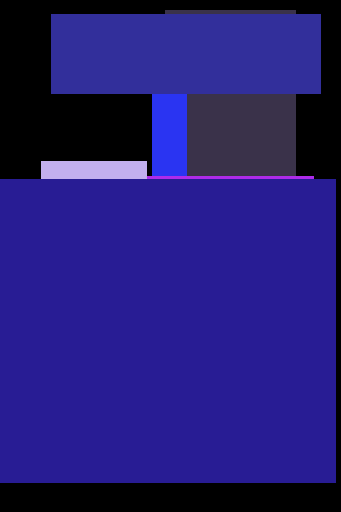

In [4]:
# 1. Load Image (using your updated function with default 512px)
original_img, w, h = load_img("./test.png")

old_fitness = fitness_score

gen: list[SVGShape] = []

# Loop to create 10 random Rectangles
for i in range(10):
    # We pass the class 'Rect' to your function
    new_shape = get_random_shape(Rect, w, h, min_size=25)
    gen.append(new_shape)

# Generate Phenotype (Render all 10 shapes onto one image)
phenotype = generate_phenotype(w, h, gen)

# Evaluate Fitness (Calculate distance)
fitness_score = compute_fitness(original_img, phenotype)

# Results
print(f"Genotype size: {len(gen)} shape(s)")
print(f"Fitness Score: {fitness_score:,}")
print(f"Improvement: {old_fitness - fitness_score:,}")

gen_img = Image.fromarray(phenotype)
gen_img

First let's implement a first draft of mutations. We will implement the easiest mutations:
- add
- recolor
- resize

For a cleaner code and easier use I will refactor genotype into a class that:
- Holds image dimensions
- The current list of shapes (what was the genotype up till now)

In [5]:
class Genotype:
    def __init__(self, w: int, h: int):
        self.w = w  # img width
        self.h = h  # img height
        self.shapes: list[SVGShape] = [] # DNA / list of shapes



Let's try to implement hill climbing (seems to be the simplest for now).

```
def  local_search(initial_solution):
    best  =  current  =  initial_solution
    while  not  stopping_condition(): 
    neighbour  =  mutate(current) 
    if  fitness(neighbour)  <  fitness(best):
        best  =  current  =  neighbour 
    elif  accept(neighbour):
        current  =  neighbour 
        
    return  best

```

In [6]:
import numpy as np
from utils import apply_mutation
from genotype import Genotype

def local_search(geno: Genotype, original_img: np.ndarray, shape_class: type[SVGShape], max_it: int = 1000) -> Genotype:
    """
    Performs a simple Hill Climbing Local Search to optimize the genotype.
    
    Args:
        geno: The starting genotype.
        original_img: The target image (numpy array).
        shape_class: The type of shape to use for 'add' mutations (Rect, Circle, etc.).
        max_it: Number of iterations to run.
    """
    
    # 1. Initialize Best Solution
    # We clone the input so we don't modify the original object outside this function
    best_geno = geno.clone()
    
    # Calculate the starting score (Cost) so we have a baseline
    best_phenotype = generate_phenotype(best_geno.w, best_geno.h, best_geno.shapes)
    best_score = compute_fitness(original_img, best_phenotype)
    
    print(f"Starting Local Search... Initial Score: {best_score:,}")

    # 2. Search Loop
    for i in range(max_it):
        
        # Create a Neighbour (Clone of current best)
        # We start from the 'best' state every time
        neighbour = best_geno.clone()
        
        # Mutate the Neighbour
        apply_mutation(neighbour, shape_class=shape_class, mutation_type="random")
        
        # Evaluate Neighbour
        # Generate the image for neighbour
        neighbour_phenotype = generate_phenotype(neighbour.w, neighbour.h, neighbour.shapes)
        neighbour_score = compute_fitness(original_img, neighbour_phenotype)
        
        # Selection (Hill Climbing)
        if neighbour_score < best_score:
            # We found a better solution! Update our 'best'.
            best_geno = neighbour
            best_score = neighbour_score
            
            # Print progress occasionally
            if i % 100 == 0:
                 print(f"Iter {i}: New Best Score -> {best_score:,}")
    
    print(f"Local Search Finished. Final Score: {best_score:,}")
    return best_geno


Let's test out this local search.

Image loaded and resized to: 400x600
Starting Local Search... Initial Score: 7,213,693,897
Iter 0: New Best Score -> 6,523,922,098
Iter 400: New Best Score -> 1,720,950,620
Iter 2500: New Best Score -> 1,210,283,547
Iter 10200: New Best Score -> 1,006,200,183
Iter 27900: New Best Score -> 933,950,761
Iter 48700: New Best Score -> 906,445,352
Local Search Finished. Final Score: 743,308,765
Final Genotype has 31 shape(s).


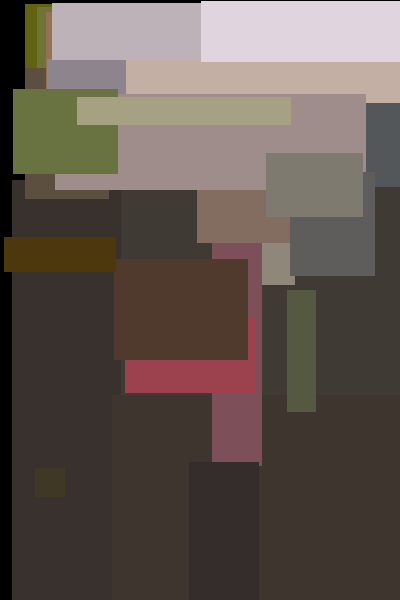

In [9]:

IMAGE_PATH = "./test.png"
MAX_ITERATIONS = 100000
SELECTED_SHAPE = Rect  # We will build the image using only Rectangles for now

# Load the target image
original_img, w, h = load_img(IMAGE_PATH, max_size=600) 

# 3. Initialize the Genotype (Empty)
start_geno = Genotype(w, h)

# Add 1 initial random shape so we don't start empty
start_geno.shapes.append(get_random_shape(SELECTED_SHAPE, w, h))

# 4. Run the Local Search
# This uses the function we just wrote to improve the image
final_geno = local_search(
    geno=start_geno, 
    original_img=original_img, 
    shape_class=SELECTED_SHAPE, 
    max_it=MAX_ITERATIONS
)

# 5. Render and Display the Final Result
print(f"Final Genotype has {len(final_geno.shapes)} shape(s).")
final_phenotype = generate_phenotype(w, h, final_geno.shapes)
Image.fromarray(final_phenotype)


So brute force is a no-no. 
Now is time to add new heuristics, first 

## Metaheuristique 
- Distribution de la couleur
- Le step essayer pas trop loin